**1). Выбор фреймворка/библиотеки для использования детектора**


Здесь я решил выбрать torchvision, так как:

*   Я уже немного с ним общался во время курса (много материала)
*   Есть возможность использовать модель "из коробки"





In [1]:
# after reinstalling, it is advisable to restart the runtime
! pip uninstall albumentations
! pip install albumentations==0.4.6

Uninstalling albumentations-0.1.12:
  Would remove:
    /usr/local/lib/python3.6/dist-packages/albumentations-0.1.12.dist-info/*
    /usr/local/lib/python3.6/dist-packages/albumentations/*
Proceed (y/n)? y
  Successfully uninstalled albumentations-0.1.12
     |████████████████████████████████| 122kB 19.0MB/s 
     |████████████████████████████████| 952kB 37.1MB/s 
  Created wheel for albumentations: filename=albumentations-0.4.6-cp36-none-any.whl size=65164 sha256=cb56419342f5c32c4286fdcd4a2a00fde4ae7804b70d4faf7bd5f7f51ccbc994
  Stored in directory: /root/.cache/pip/wheels/c7/f4/89/56d1bee5c421c36c1a951eeb4adcc32fbb82f5344c086efa14
Successfully built albumentations
  Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9


In [2]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


In [3]:
device = torch.device("cuda")

In [4]:
model = model.to(device)

**2). Запуск детектора на случайных изображениях**

In [5]:
# load pictures
!wget https://i.ytimg.com/vi/cqxhdf3BZJg/maxresdefault.jpg
!mv maxresdefault.jpg test_1.jpg

!wget https://avatars.mds.yandex.net/get-altay/1908863/2a00000169e53a6b47f71ed9f0170e405ee9/XXXL
!mv XXXL test_2.jpg

!wget https://avatars.mds.yandex.net/get-ugc/903060/2a0000015f5ad0c494e83a1001f56d422eab/XXXL
!mv XXXL test_3.jpg

--2021-02-09 19:47:44--  https://i.ytimg.com/vi/cqxhdf3BZJg/maxresdefault.jpg
Resolving i.ytimg.com (i.ytimg.com)... 172.217.9.214, 2607:f8b0:4004:806::2016
Connecting to i.ytimg.com (i.ytimg.com)|172.217.9.214|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 110405 (108K) [image/jpeg]
Saving to: ‘maxresdefault.jpg’

maxresdefault.jpg   100%[===================>] 107.82K  --.-KB/s    in 0.02s   

2021-02-09 19:47:44 (4.46 MB/s) - ‘maxresdefault.jpg’ saved [110405/110405]

--2021-02-09 19:47:44--  https://avatars.mds.yandex.net/get-altay/1908863/2a00000169e53a6b47f71ed9f0170e405ee9/XXXL
Resolving avatars.mds.yandex.net (avatars.mds.yandex.net)... 87.250.247.183, 87.250.247.182, 87.250.247.181, ...
Connecting to avatars.mds.yandex.net (avatars.mds.yandex.net)|87.250.247.183|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 154090 (150K) [image/jpeg]
Saving to: ‘XXXL’

XXXL                100%[===================>] 150.48K   385KB/s    in 0

In [6]:
# function for prediction (taken from practice CV 2019)
def get_preds(model, img_path):
    model = model.eval()
    img_numpy = cv2.imread(img_path)[:,:,::-1]
    img = torch.from_numpy(img_numpy.astype('float32')).permute(2,0,1)
    img = img.to(device)
    img = img / 255
    
    predictions = model(img[None,...])

    CONF_THRESH = 0.5

    boxes = predictions[0]['boxes'][predictions[0]['scores'] > CONF_THRESH]
    boxes_dict = {}
    boxes_dict['boxes'] = boxes 
    boxes_dict['labels'] = predictions[0]['labels']
    return predictions, boxes_dict

# function for showing predictions (I took the CV 2019 from practice and added it to have the text of the class)
def plot_preds(img_path, preds, text_size, color, text_width):
    numpy_img = cv2.imread(img_path)[:,:,::-1]
    boxes = preds['boxes'].detach().cpu().numpy()
    labels = preds['labels']
    for i in range(len(boxes)):
        box = boxes[i]
        numpy_img = cv2.rectangle(
            numpy_img, 
            (box[0],box[1]),
            (box[2],box[3]), 
            255,
            3)
        cv2.putText(numpy_img, 
                    COCO_INSTANCE_CATEGORY_NAMES[labels[i]], 
                    (box[0], box[1]), 
                    cv2.FONT_HERSHEY_SIMPLEX, 
                    text_size, 
                    color, 
                    thickness=text_width)
    return numpy_img.get()

# the function is just for convenience (so that you can test 1 line)
def test_img(model, img_path, text_size=0.75, color=(255,0,0), text_width=3):
    preds, boxes = get_preds(model, img_path)
    img_with_boxes = plot_preds(img_path, boxes, text_size, color, text_width)
    return img_with_boxes

COCO_INSTANCE_CATEGORY_NAMES = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A',
    'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
    'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
    'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table',
    'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
    'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book',
    'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]

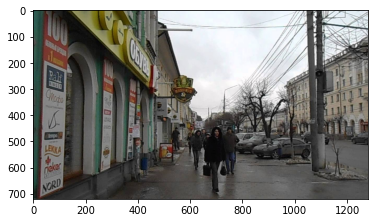

In [7]:
plt.imshow(cv2.imread('test_1.jpg')[:, :, ::-1])

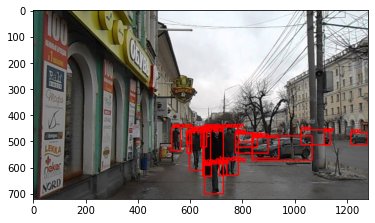

In [8]:
# далее идут сами тесты
plt.imshow(test_img(model, 'test_1.jpg').astype('uint'))

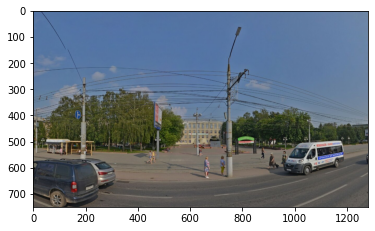

In [9]:
plt.imshow(cv2.imread('test_2.jpg')[:, :, ::-1])

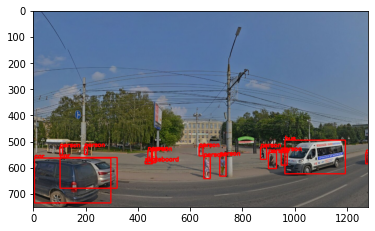

In [10]:
plt.imshow(test_img(model, 'test_2.jpg').astype('uint'))

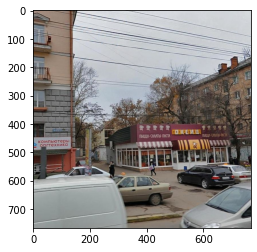

In [11]:
plt.imshow(cv2.imread('test_3.jpg')[:, :, ::-1])

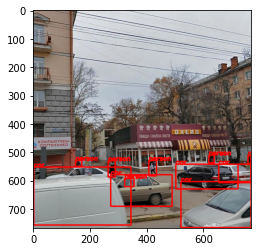

In [12]:
plt.imshow(test_img(model, 'test_3.jpg').astype('uint'))

На мой взгляд, результат детекции довольно хороший, модель даже умеет "достраивать" box'ы изображений до реальнх (машина слева внизу на 2й картинке) и очень четко разделяет близкие между собой на картинке объекты (1я картинка)

**3) Выбор датасета**


Изначально я хотел придумать свою задачу для детекции, собрать и разметить собственный датасет, однако в связи с региональными этапами ВСОШа и еще несколькими олимпиадами из РСОШа, у меня не хватило времени на всё. Поэтому я решил выбрать датасет для детекции фруктов

In [13]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# archive.zip archive downloaded from kaggle (contains both train and test)
!unzip /content/drive/MyDrive/archive.zip -d /content/

**4) Предобработка данных**

In [15]:
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from tqdm import tqdm
import torch.nn as nn
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
from PIL import Image
from xml.dom.minidom import parse
from torchvision.transforms import functional as F

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

In [16]:
# I look at the number of classes
train_files = os.listdir('train_zip/train')
train_files = [x[:x.index('_')] for x in train_files]
set(train_files)

{'apple', 'banana', 'mixed', 'orange'}

In [17]:
NUM_CLASSES = 4
CLASSES = ['mixed', 'apple', 'banana', 'orange']

In [18]:
!mkdir train
!mkdir test
!mkdir train/JPEGImages
!mkdir train/Annotations
!mkdir test/JPEGImages
!mkdir test/Annotations

In [19]:
# I slightly change the location of the files for convenience
import os, shutil
train_path = "train_zip/train/"
test_path = "test_zip/test/"
train_files = os.listdir(train_path)
test_files = os.listdir(test_path)
train_img_path = "train/JPEGImages/"
train_ano_path = "train/Annotations/"
test_img_path = "test/JPEGImages/"
test_ano_path = "test/Annotations/"
for x in train_files:
    print(x)
    if 'xml' in x:
        shutil.move(train_path+x, train_ano_path+x)
    else:
        shutil.move(train_path+x, train_img_path+x)
for x in test_files:
    if 'xml' in x:
        shutil.move(test_path+x, test_ano_path+x)
    else:
        shutil.move(test_path+x, test_img_path+x)

banana_40.xml
banana_61.xml
banana_55.xml
orange_75.xml
banana_14.jpg
orange_41.jpg
apple_50.xml
banana_56.jpg
mixed_9.xml
apple_31.jpg
banana_65.jpg
orange_31.jpg
banana_25.xml
banana_22.jpg
orange_68.jpg
banana_43.jpg
orange_70.jpg
orange_71.xml
orange_72.xml
apple_38.xml
orange_19.xml
orange_44.xml
orange_69.jpg
apple_64.xml
apple_36.jpg
orange_29.jpg
orange_9.xml
banana_44.xml
orange_44.jpg
apple_16.xml
banana_33.jpg
apple_42.xml
apple_70.xml
orange_57.jpg
apple_26.xml
orange_47.xml
apple_46.jpg
mixed_16.jpg
apple_11.xml
apple_7.jpg
orange_4.xml
banana_72.jpg
apple_61.xml
banana_40.jpg
mixed_2.jpg
mixed_7.xml
orange_46.jpg
banana_34.xml
apple_74.xml
apple_47.xml
orange_9.jpg
mixed_15.xml
apple_45.jpg
apple_41.xml
banana_11.xml
apple_65.xml
orange_6.jpg
apple_30.xml
banana_16.xml
banana_5.jpg
apple_37.jpg
banana_51.xml
apple_2.xml
apple_63.jpg
orange_13.jpg
apple_48.xml
banana_36.jpg
apple_4.xml
mixed_19.jpg
apple_15.xml
banana_74.jpg
apple_69.jpg
orange_13.xml
orange_37.xml
banana_

In [20]:
class FruitDataset(Dataset):
    def __init__(self, root, transforms=None):
        self.root = root
        self.transforms = transforms
        self.imgs = list(sorted(os.listdir(os.path.join(root, "JPEGImages"))))
        self.bbox_xml = list(sorted(os.listdir(os.path.join(root, "Annotations"))))
 
    def __getitem__(self, idx):
        img_path = os.path.join(self.root, "JPEGImages", self.imgs[idx])
        bbox_xml_path = os.path.join(self.root, "Annotations", self.bbox_xml[idx])
        img_numpy = cv2.imread(img_path)[:,:,::-1]
        img = torch.from_numpy(img_numpy.astype('float32')).permute(2,0,1)
        img = img / 255        
        dom = parse(bbox_xml_path)
        data = dom.documentElement
        objects = data.getElementsByTagName('object') 
        boxes = []
        labels = []
        for object_ in objects:
            name = object_.getElementsByTagName('name')[0].childNodes[0].nodeValue 
            labels.append(CLASSES.index(name)) 
            
            bndbox = object_.getElementsByTagName('bndbox')[0]
            xmin = np.float(bndbox.getElementsByTagName('xmin')[0].childNodes[0].nodeValue)
            ymin = np.float(bndbox.getElementsByTagName('ymin')[0].childNodes[0].nodeValue)
            xmax = np.float(bndbox.getElementsByTagName('xmax')[0].childNodes[0].nodeValue)
            ymax = np.float(bndbox.getElementsByTagName('ymax')[0].childNodes[0].nodeValue)
            boxes.append([xmin, ymin, xmax, ymax])        
 
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)        
 
        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        iscrowd = torch.zeros((len(objects),), dtype=torch.int64)
 
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd
 
        if self.transforms is not None:
            img, target = self.transforms(img, target)
 
        return img, target, self.imgs[idx]
 
    def __len__(self):
        return len(self.imgs)

In [21]:
train_dataset = FruitDataset('train/')
test_dataset = FruitDataset('test/')

In [22]:
train_dataset[5]

(tensor([[[0.8706, 0.8510, 0.8275,  ..., 0.4824, 0.4510, 0.4941],
          [0.9137, 0.8941, 0.8745,  ..., 0.4627, 0.4706, 0.5412],
          [0.9529, 0.9412, 0.9216,  ..., 0.5098, 0.5333, 0.5882],
          ...,
          [0.2314, 0.2353, 0.2431,  ..., 0.2784, 0.2275, 0.1961],
          [0.2196, 0.2235, 0.2314,  ..., 0.2784, 0.2157, 0.1804],
          [0.2196, 0.2235, 0.2314,  ..., 0.3961, 0.3216, 0.2078]],
 
         [[0.9020, 0.8902, 0.8627,  ..., 0.7137, 0.6902, 0.7451],
          [0.9412, 0.9294, 0.9137,  ..., 0.6824, 0.7059, 0.7922],
          [0.9725, 0.9608, 0.9529,  ..., 0.7137, 0.7569, 0.8196],
          ...,
          [0.3490, 0.3529, 0.3608,  ..., 0.4980, 0.4431, 0.4078],
          [0.3490, 0.3529, 0.3608,  ..., 0.5020, 0.4353, 0.4000],
          [0.3490, 0.3529, 0.3608,  ..., 0.6196, 0.5451, 0.4275]],
 
         [[0.9529, 0.9373, 0.9216,  ..., 0.1490, 0.1843, 0.2627],
          [0.9804, 0.9647, 0.9529,  ..., 0.1451, 0.2196, 0.3216],
          [0.9843, 0.9725, 0.9647,  ...,

**5) Обучение модели детектора**

(для начала создание необученной модели)

In [23]:
# creating a folder with weights
!mkdir model_weights

In [24]:
# class for easy loss calculation
class Averager:
    def __init__(self):
        self.current_total = 0.0
        self.iterations = 0.0

    def send(self, value):
        self.current_total += value
        self.iterations += 1

    @property
    def value(self):
        if self.iterations == 0:
            return 0
        else:
            return 1.0 * self.current_total / self.iterations

    def reset(self):
        self.current_total = 0.0
        self.iterations = 0.0

def collate_fn(batch):
    return tuple(zip(*batch))

def fit(model, train_data_loader, optimizer, lr_scheduler):
    train_loss = Averager()
    train_loss_classifier = Averager()
    train_loss_box_reg = Averager()
    train_loss_objectness = Averager()
    train_loss_rpn_box_reg = Averager()

    for images, targets, image_ids in train_data_loader:
  
          images = list(image.to(device) for image in images)
          targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

          loss_dict = model(images, targets)

          losses = sum(loss for loss in loss_dict.values())
          loss_value = losses.item()

          train_loss.send(loss_value)
          train_loss_classifier.send(float(loss_dict['loss_classifier']))
          train_loss_box_reg.send(float(loss_dict['loss_box_reg']))
          train_loss_objectness.send(float(loss_dict['loss_objectness']))
          train_loss_rpn_box_reg.send(float(loss_dict['loss_rpn_box_reg']))

          optimizer.zero_grad()
          losses.backward()
          optimizer.step()

    return {'hist':train_loss.value,
            'classifier':train_loss_classifier.value,
            'box_reg':train_loss_box_reg.value,
            'objectness':train_loss_objectness.value,
            'rpn_box_reg':train_loss_rpn_box_reg.value}

def eval(model, test_data_loader, optimizer, lr_scheduler):
    test_loss = Averager()
    test_loss_classifier = Averager()
    test_loss_box_reg = Averager()
    test_loss_objectness = Averager()
    test_loss_rpn_box_reg = Averager()

    for images, targets, image_ids in train_data_loader:
  
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        with torch.set_grad_enabled(False):
            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())
            loss_value = losses.item()
            test_loss.send(loss_value)

            test_loss_classifier.send(float(loss_dict['loss_classifier']))
            test_loss_box_reg.send(float(loss_dict['loss_box_reg']))
            test_loss_objectness.send(float(loss_dict['loss_objectness']))
            test_loss_rpn_box_reg.send(float(loss_dict['loss_rpn_box_reg']))

    return {'hist':test_loss.value,
            'classifier':test_loss_classifier.value,
            'box_reg':test_loss_box_reg.value,
            'objectness':test_loss_objectness.value,
            'rpn_box_reg':test_loss_rpn_box_reg.value}


def train(model, train_data_loader, test_data_loader, num_epochs, optimizer, lr_scheduler):

    train_loss_hist = Averager()
    test_loss_hist = Averager()

    # losses for each parameter
    train_loss_classifier = Averager()
    train_loss_box_reg = Averager()
    train_loss_objectness = Averager()
    train_loss_rpn_box_reg = Averager()

    test_loss_classifier = Averager()
    test_loss_box_reg = Averager()
    test_loss_objectness = Averager()
    test_loss_rpn_box_reg = Averager()

    itr = 1
    hist = []
    for epoch in tqdm(range(num_epochs)):
        # resetting losses
        train_loss_hist.reset()
        test_loss_hist.reset()

        train_loss_classifier.reset()
        train_loss_box_reg.reset()
        train_loss_objectness.reset()
        train_loss_rpn_box_reg.reset()
    
        test_loss_classifier.reset()
        test_loss_box_reg.reset()
        test_loss_objectness.reset()
        test_loss_rpn_box_reg.reset()

        # Training of the 1 epoch
        fit_loss = fit(model, train_data_loader, optimizer, lr_scheduler)

        train_loss_hist.send(fit_loss['hist'])
        train_loss_classifier.send(fit_loss['classifier'])
        train_loss_box_reg.send(fit_loss['box_reg'])
        train_loss_objectness.send(fit_loss['objectness'])
        train_loss_rpn_box_reg.send(fit_loss['rpn_box_reg'])

        # saving weights
        torch.save(model, f'model_weights/faster_rcnn_after_{epoch+1}_epochs.pth')

        # validation
        val_loss = eval(model, test_data_loader, optimizer, lr_scheduler)
    
        test_loss_hist.send(val_loss['hist'])
        test_loss_classifier.send(val_loss['classifier'])
        test_loss_box_reg.send(val_loss['box_reg'])
        test_loss_objectness.send(val_loss['objectness'])
        test_loss_rpn_box_reg.send(val_loss['rpn_box_reg'])

        if lr_scheduler is not None:
            lr_scheduler.step()
        hist.append([train_loss_hist.value,
                     train_loss_classifier.value,
                     train_loss_box_reg.value,
                     train_loss_objectness.value,
                     train_loss_rpn_box_reg.value,
                     test_loss_hist.value,
                     test_loss_classifier.value,
                     test_loss_box_reg.value,
                     test_loss_objectness.value,
                     test_loss_rpn_box_reg.value])

        print(f"\nEpoch № {epoch+1}")   
        print(f'Training losses:\n loss: {train_loss_hist.value}  loss_classifier: {train_loss_classifier.value}  \
loss_box_reg: {train_loss_box_reg.value} loss_objectness: {train_loss_objectness.value}  \
loss_rpn_box_reg: {train_loss_rpn_box_reg.value}')
        print(f'Validation losses:\n loss: {test_loss_hist.value}  loss_classifier: {test_loss_classifier.value}  \
loss_box_reg: {test_loss_box_reg.value} loss_objectness: {test_loss_objectness.value}  \
loss_rpn_box_reg: {test_loss_rpn_box_reg.value}')
        print('\n----------------------------------------------------------------------\n')
    return hist

In [25]:
def _flip_coco_person_keypoints(kps, width):
    flip_inds = [0, 2, 1, 4, 3, 6, 5, 8, 7, 10, 9, 12, 11, 14, 13, 16, 15]
    flipped_data = kps[:, flip_inds]
    flipped_data[..., 0] = width - flipped_data[..., 0]
    inds = flipped_data[..., 2] == 0
    flipped_data[inds] = 0
    return flipped_data


class Compose(object):
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, image, target):
        for t in self.transforms:
            image, target = t(image, target)
        return image, target


class RandomHorizontalFlip(object):
    def __init__(self, prob):
        self.prob = prob

    def __call__(self, image, target):
        if np.random.random() < self.prob:
            height, width = image.shape[-2:]
            image = image.flip(-1)
            bbox = target["boxes"]
            bbox[:, [0, 2]] = width - bbox[:, [2, 0]]
            target["boxes"] = bbox
            if "masks" in target:
                target["masks"] = target["masks"].flip(-1)
            if "keypoints" in target:
                keypoints = target["keypoints"]
                keypoints = _flip_coco_person_keypoints(keypoints, width)
                target["keypoints"] = keypoints
        return image, target


class ToTensor(object):
    def __call__(self, image, target):
        image = F.to_tensor(image)
        return image, target

def get_transform(train):
    transforms = []
    if train:
        transforms.append(RandomHorizontalFlip(0.5))
 
    return Compose(transforms)

In [30]:
# clearing the weights folder
for x in os.listdir('model_weights'):
    os.remove(f"model_weights/{x}")

In [28]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=False, progress=True, num_classes=4, pretrained_backbone=True)
model = model.to(device)


num_classes = 4
train_dataset = FruitDataset('train/', get_transform(True))
val_dataset = FruitDataset('test/', get_transform(False))

train_data_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=1, shuffle=True, 
    collate_fn=collate_fn)

test_data_loader = torch.utils.data.DataLoader(
    val_dataset, batch_size=1, shuffle=False,
    collate_fn=collate_fn)

params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.AdamW(params, lr=5e-6)


lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=1, T_mult=2)

num_epochs = 120

In [ ]:
history = train(model, train_data_loader, test_data_loader, num_epochs, optimizer, lr_scheduler)

In [ ]:
train_loss, train_classifier, train_box_reg, train_objectness, train_rpn_box_reg, test_loss, test_classifier, test_box_reg, test_objectness, test_rpn_box_reg = zip(*history) 

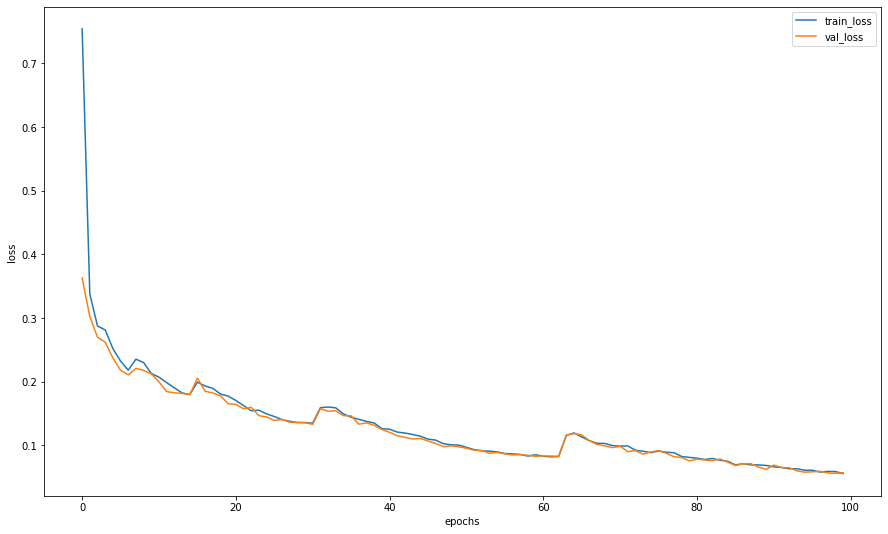

In [ ]:
plt.figure(figsize=(15, 9))
plt.plot(train_loss, label="train_loss")
plt.plot(test_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

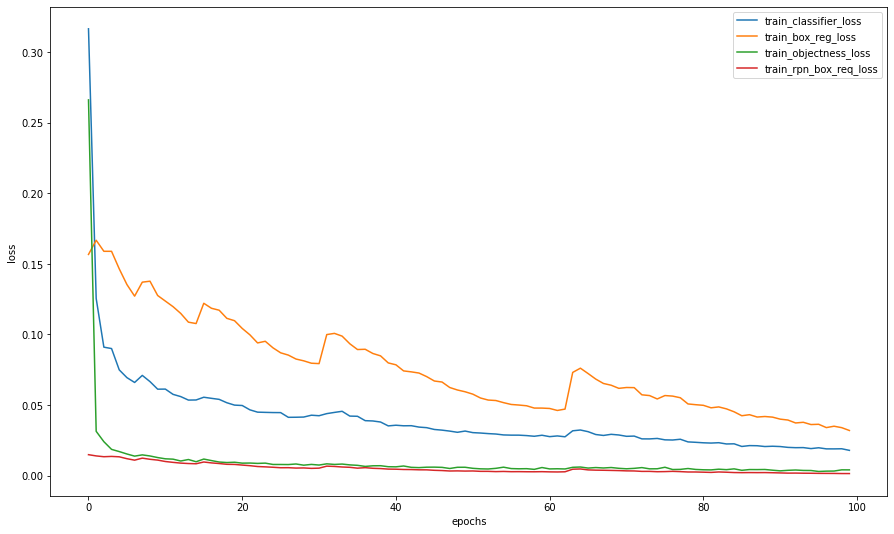

In [ ]:
plt.figure(figsize=(15, 9))
plt.plot(train_classifier, label="train_classifier_loss")
plt.plot(train_box_reg, label="train_box_reg_loss")
plt.plot(train_objectness, label="train_objectness_loss")
plt.plot(train_rpn_box_reg, label="train_rpn_box_req_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

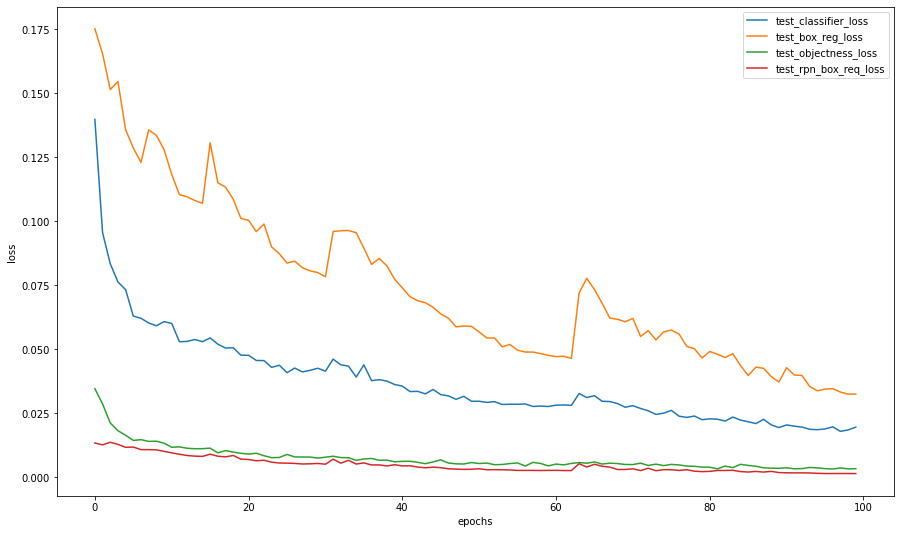

In [ ]:
plt.figure(figsize=(15, 9))
plt.plot(test_classifier, label="test_classifier_loss")
plt.plot(test_box_reg, label="test_box_reg_loss")
plt.plot(test_objectness, label="test_objectness_loss")
plt.plot(test_rpn_box_reg, label="test_rpn_box_req_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

**Результаты обучения**

In [ ]:
def get_preds(model, img_path):
    model = model.eval()
    img_numpy = cv2.imread(img_path)[:,:,::-1]
    img = torch.from_numpy(img_numpy.astype('float32')).permute(2,0,1)
    img = img.to(device)
    img = img / 255
    
    predictions = model(img[None,...])

    CONF_THRESH = 0.5

    boxes = predictions[0]['boxes'][predictions[0]['scores'] > CONF_THRESH]
    boxes_dict = {}
    boxes_dict['boxes'] = boxes 
    boxes_dict['labels'] = predictions[0]['labels']
    return predictions, boxes_dict

def plot_preds(img_path, preds, text_size, color, text_width):
    numpy_img = cv2.imread(img_path)[:,:,::-1]
    boxes = preds['boxes'].detach().cpu().numpy()
    labels = preds['labels']
    for i in range(len(boxes)):
        box = boxes[i]
        numpy_img = cv2.rectangle(
            numpy_img, 
            (box[0],box[1]),
            (box[2],box[3]), 
            255,
            3)
        cv2.putText(numpy_img, 
                    CLASSES[labels[i]], 
                    (box[0], box[1]), 
                    cv2.FONT_HERSHEY_SIMPLEX, 
                    text_size, 
                    color, 
                    thickness=text_width)
    return numpy_img.get()

def test_img(model, img_path, text_size=2, color=(255,0,0), text_width=3):
    preds, boxes = get_preds(model, img_path)
    print(preds, boxes)
    img_with_boxes = plot_preds(img_path, boxes, text_size, color, text_width)
    return img_with_boxes

In [ ]:
img_path = f"test/JPEGImages/{np.random.choice(os.listdir('test/JPEGImages'))}"
img_path

'test/JPEGImages/mixed_22.jpg'

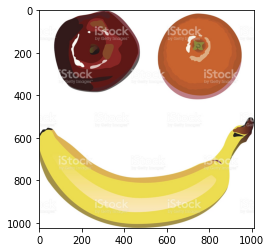

In [ ]:
plt.imshow(cv2.imread(img_path)[:,:,::-1])

[{'boxes': tensor([[  0.0000, 570.4039, 951.4978, 994.8951],
        [ 49.9133,  34.2978, 460.7348, 375.4009],
        [562.4152,  48.5020, 950.6400, 399.4308],
        [539.1187,  32.6737, 966.2997, 403.3491]], device='cuda:0',
       grad_fn=<StackBackward>), 'labels': tensor([2, 1, 3, 1], device='cuda:0'), 'scores': tensor([0.9990, 0.9312, 0.8500, 0.3108], device='cuda:0',
       grad_fn=<IndexBackward>)}] {'boxes': tensor([[  0.0000, 570.4039, 951.4978, 994.8951],
        [ 49.9133,  34.2978, 460.7348, 375.4009],
        [562.4152,  48.5020, 950.6400, 399.4308]], device='cuda:0',
       grad_fn=<IndexBackward>), 'labels': tensor([2, 1, 3, 1], device='cuda:0')}


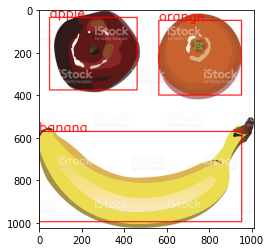

In [ ]:
plt.imshow(test_img(model, img_path).astype('uint'))

В целом, вроде, работает неплохо. Но могло бы быть и лучше

**6) Измерение качества работы модели**

In [ ]:
def get_scores(model, test_path, iou_size):
    # 1st number это TP, 2nd - FP, 3rd - FN 
    scores = {'apple': [0, 0, 0],
              'banana': [0, 0, 0],
              'orange': [0, 0, 0]}

    for x in os.listdir(test_path+'JPEGImages/'):
        img = cv2.imread(test_path+'JPEGImages/'+x)
        data = parse(test_path+'Annotations/'+x[:-3]+'xml').documentElement

        objects = data.getElementsByTagName('object') 
        boxes = []
        labels = []
        for object_ in objects:
            name = object_.getElementsByTagName('name')[0].childNodes[0].nodeValue 
            labels.append(CLASSES.index(name)) 
            
            bndbox = object_.getElementsByTagName('bndbox')[0]
            xmin = np.float(bndbox.getElementsByTagName('xmin')[0].childNodes[0].nodeValue)
            ymin = np.float(bndbox.getElementsByTagName('ymin')[0].childNodes[0].nodeValue)
            xmax = np.float(bndbox.getElementsByTagName('xmax')[0].childNodes[0].nodeValue)
            ymax = np.float(bndbox.getElementsByTagName('ymax')[0].childNodes[0].nodeValue)
            boxes.append([xmin, ymin, xmax, ymax])       

        preds, box = get_preds(model, test_path+'JPEGImages/'+x) 
        preds_boxes, preds_labels = preds[0]['boxes'], preds[0]['labels']

        usg = [0 for i in range(len(boxes))]  # array for indicating found objects (0 - not found, 1-found)
        for i in range(len(preds_boxes)):
            preds_box = preds_boxes[i]
            iou = 0
            # With this cycle, I look for matches in boxes and predictions
            for j in range(len(boxes)):
                x = boxes[j]
                iou = max(iou, (min(preds_box[2], x[2]) - max(preds_box[0], x[0])) * (min(x[3], preds_box[3]) - max(x[1], preds_box[1])))
                iou /= ((x[2]-x[0]) * (x[3]-x[1]) + (preds_box[2]-preds_box[0]) * (preds_box[3]-preds_box[1]) - iou)
                if iou >= iou_size: # if the total area is greater than a certain value , the network has found the object
                    if labels[j] == preds_labels[i]:
                        scores[CLASSES[labels[j]]][0] += 1
                        usg[j] = 1 
                        break
            # if the network predicted an object that doesn't actually exist , it's FP
            else:
                scores[CLASSES[preds_labels[i]]][1] += 1
        # well, all the source objects that the neural network did not find - FN
        for i in range(len(usg)):
            if not usg[i]:
                scores[CLASSES[labels[i]]][2] += 1
    # precision = tp/(tp+fp), recall = tp/(tp+fn), f1 = 2*presicion*recall/(precision+recall)
    results = [['apple', scores['apple'][0]/(scores['apple'][0]+scores['apple'][1]), scores['apple'][0]/(scores['apple'][0]+scores['apple'][2])],
              ['banana', scores['banana'][0]/(scores['banana'][0]+scores['banana'][1]), scores['banana'][0]/(scores['banana'][0]+scores['banana'][2])],
              ['orange', scores['orange'][0]/(scores['orange'][0]+scores['orange'][1]), scores['orange'][0]/(scores['orange'][0]+scores['orange'][2])]]
    for i in range(len(results)):
        results[i].append(2*results[i][-1]*results[i][1]/(results[i][1]+results[i][-1]))
    return pd.DataFrame(results, columns=['Class', 'Precision', 'Recall', 'F1'])

get_scores(model, 'test/', 0.4)

,Class,Precision,Recall,F1
0,apple,0.661972,0.959184,0.783333
1,banana,0.604938,0.844828,0.705036
2,orange,0.706667,0.963636,0.815385


In [ ]:
get_scores(model, 'train/', 0.4)

,Class,Precision,Recall,F1
0,apple,0.920833,0.986607,0.952586
1,banana,0.827381,0.939189,0.879747
2,orange,0.871429,1.000000,0.931298


In [ ]:
# code for finding the optimal weights of the model
best_f1 = 0
best_epoch = ''
for x in os.listdir('model_weights'):
    print(f"Current model: {x}")
    model = torch.load(f'model_weights/{x}')
    q = get_scores(model, 'test/', 0.5)['F1']
    if q.mean() > best_f1:
        best_f1 = q.mean()
        best_epoch = x[:]
    print(f"best_f1: {best_f1}")

In [ ]:
model = torch.load(f"model_weights/{best_epoch}")
get_scores(model, 'test/', 0.5)

,Class,Precision,Recall,F1
0,apple,0.547945,0.952381,0.695652
1,banana,0.529412,0.833333,0.647482
2,orange,0.561644,0.931818,0.700855


In [ ]:
files.download(f"model_weights/{best_epoch}")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


Можно заметить, что нейросеть редко видит объекты там, где их нет, но при этом и не всегда замечает объекты там, где они есть. 

**7) Применение в реальных задачах**

Детектирование фруктов можно применять:


*   На конвейерных предприятиях (например предприятие по автоматизированному приготовлению пирогов/тортов - манипуляторы с помощью данной нейросети смогут правильно сортировать фрукты - яблоки в 1 контейнер, бананы - во 2 контейнер и т.д.)
*   Сбор фруктов с помощью дронов (дроны с помощью детекции смогут находить фрукты и собирать нужные - например пришло время собирать яблоки - дроны вылетят и соберут только яблоки)
*   Если добавить классы испорченных фруктов, то можно будет и отсеивать испорченные фрукты например на тех же самых преприятиях
*   Если (или когда) появяться роботы-помощники по дому, они смогут по приказу человека приносить ему те фрукты, которые он попросит


if you have any questions for me, you can write to me in telegram - @npocTo_naBeJI